In [ ]:
!pip install kagglehub opencv-python --quiet

In [ ]:
import os
import gc


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)

import cv2
import warnings
warnings.filterwarnings("ignore")

import kagglehub

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class_names = ["Neutrophil", "Lymphocyte", "Monocyte", "Eosinophil", "Basophil"]
num_classes = len(class_names)


In [ ]:
# Download the Kaggle dataset
dataset_path = kagglehub.dataset_download("masoudnickparvar/white-blood-cells-dataset")
print("Dataset downloaded at:", dataset_path)

train_dir = os.path.join(dataset_path, "Train")
test_dir = os.path.join(dataset_path, "Test-A")
print("Train directory:", train_dir)
print("Test directory :", test_dir)

def load_images_128(directory, class_list):
    """
    Load images at 128x128 resolution.
    Returns:
        images: (N, 128, 128, 3)
        labels: (N,)
        paths:  list of file paths
    """
    images, labels, paths = [], [], []
    target_size = 128

    for label_idx, class_name in enumerate(class_list):
        class_path = os.path.join(directory, class_name)
        if not os.path.exists(class_path):
            print("Missing path:", class_path)
            continue

        for img_file in tqdm(os.listdir(class_path), desc=f"Loading {class_name} (128x128)"):
            img_path = os.path.join(class_path, img_file)
            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize((target_size, target_size))
                images.append(np.array(img))
                labels.append(label_idx)
                paths.append(img_path)
            except Exception as e:
                print("Failed to load:", img_path, "| Error:", e)

    return np.array(images), np.array(labels), paths

# Load 128x128 data for CNN
X_train_raw_128, y_train_raw_128, train_paths_128 = load_images_128(train_dir, class_names)
X_test_raw_128, y_test_raw_128, test_paths_128 = load_images_128(test_dir, class_names)

print("Number of training images (128x128):", len(X_train_raw_128))
print("Number of test images (128x128):", len(X_test_raw_128))


100%|██████████| 499M/499M [00:07<00:00, 74.0MB/s]

Extracting files...


Dataset downloaded at: /root/.cache/kagglehub/datasets/masoudnickparvar/white-blood-cells-dataset/versions/1
Train directory: /root/.cache/kagglehub/datasets/masoudnickparvar/white-blood-cells-dataset/versions/1/Train
Test directory : /root/.cache/kagglehub/datasets/masoudnickparvar/white-blood-cells-dataset/versions/1/Test-A


Loading Neutrophil (128x128):   0%|          | 0/6231 [00:00<?, ?it/s]

Loading Lymphocyte (128x128):   0%|          | 0/2427 [00:00<?, ?it/s]

Loading Monocyte (128x128):   0%|          | 0/561 [00:00<?, ?it/s]

Loading Eosinophil (128x128):   0%|          | 0/744 [00:00<?, ?it/s]

Loading Basophil (128x128):   0%|          | 0/212 [00:00<?, ?it/s]

Loading Neutrophil (128x128):   0%|          | 0/2660 [00:00<?, ?it/s]

Loading Lymphocyte (128x128):   0%|          | 0/1034 [00:00<?, ?it/s]

Loading Monocyte (128x128):   0%|          | 0/234 [00:00<?, ?it/s]

Loading Eosinophil (128x128):   0%|          | 0/322 [00:00<?, ?it/s]

Loading Basophil (128x128):   0%|          | 0/89 [00:00<?, ?it/s]

Number of training images (128x128): 10175
Number of test images (128x128): 4339


Training class distribution:
Neutrophil: 6231 samples
Lymphocyte: 2427 samples
Monocyte: 561 samples
Eosinophil: 744 samples
Basophil: 212 samples


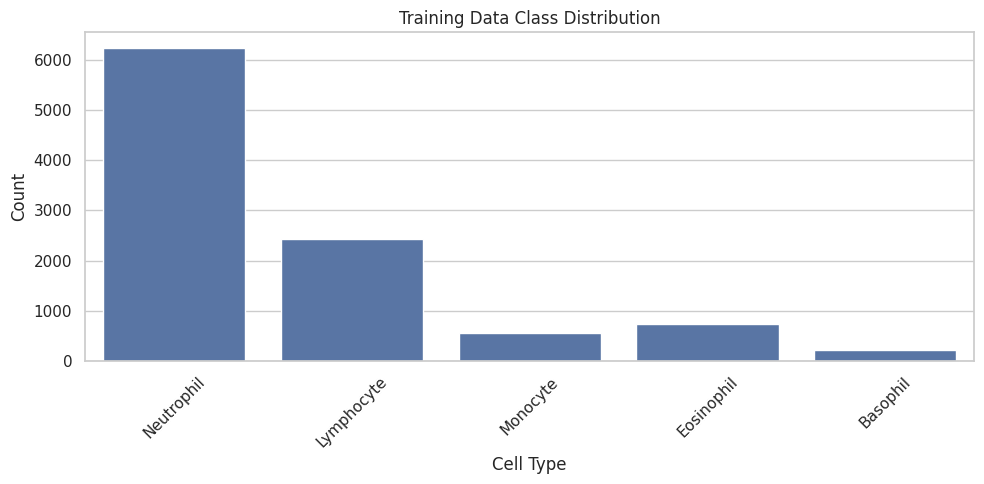

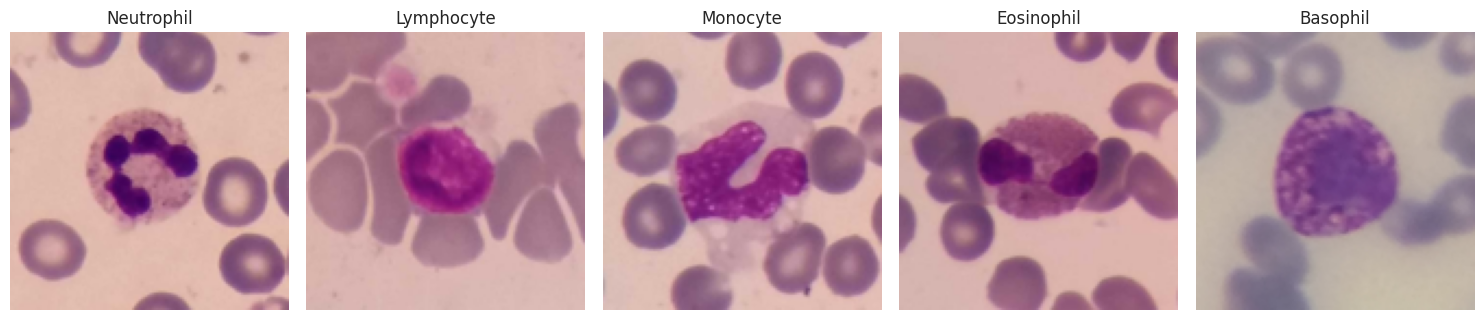

Train set shape: (8140, 128, 128, 3) (8140, 5)
Val set shape  : (2035, 128, 128, 3) (2035, 5)
Test set shape : (4339, 128, 128, 3) (4339, 5)


In [ ]:
# Class distribution for training set
print("Training class distribution:")
train_counts = np.bincount(y_train_raw_128)
for i, count in enumerate(train_counts):
    print(f"{class_names[i]}: {count} samples")

plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_raw_128)
plt.title("Training Data Class Distribution")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.xlabel("Cell Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Show one sample per class
plt.figure(figsize=(15, 6))
for idx, label in enumerate(class_names):
    indices = np.where(y_train_raw_128 == idx)[0]
    if len(indices) > 0:
        plt.subplot(1, len(class_names), idx + 1)
        plt.imshow(X_train_raw_128[indices[0]])
        plt.title(label)
        plt.axis("off")
plt.tight_layout()
plt.show()

# Normalize and split for CNN
X_all_128 = X_train_raw_128.astype("float32") / 255.0
X_test_128 = X_test_raw_128.astype("float32") / 255.0

X_train_128, X_val_128, y_train_raw_split, y_val_raw_split = train_test_split(
    X_all_128,
    y_train_raw_128,
    test_size=0.2,
    random_state=42,
    stratify=y_train_raw_128,
)

y_train_128 = tf.keras.utils.to_categorical(y_train_raw_split, num_classes)
y_val_128 = tf.keras.utils.to_categorical(y_val_raw_split, num_classes)
y_test_128 = tf.keras.utils.to_categorical(y_test_raw_128, num_classes)

print("Train set shape:", X_train_128.shape, y_train_128.shape)
print("Val set shape  :", X_val_128.shape, y_val_128.shape)
print("Test set shape :", X_test_128.shape, y_test_128.shape)


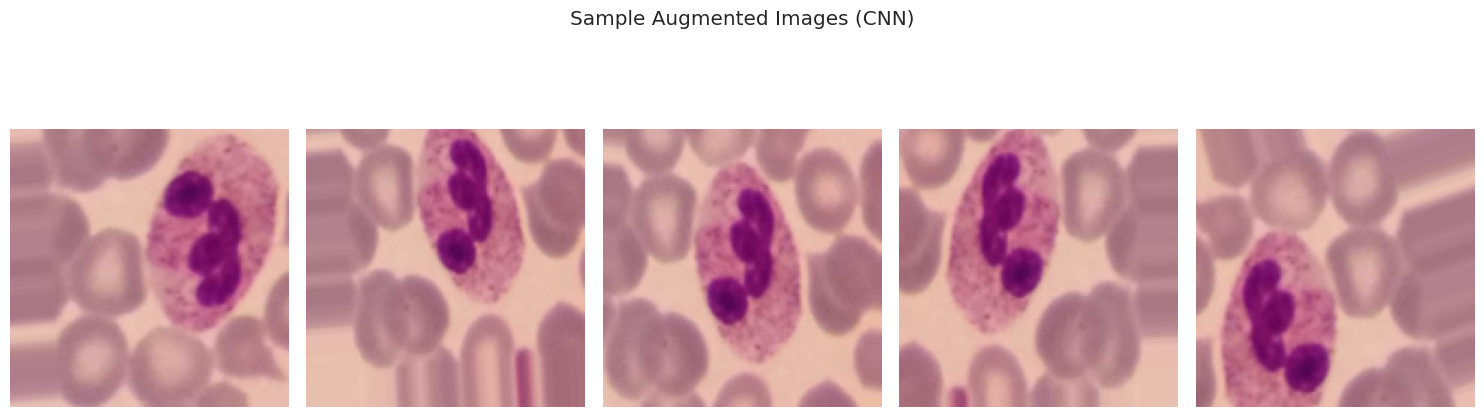

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,09

 Total params: 38,778,181 (147.93 MB)

 Trainable params: 38,773,189 (147.91 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [ ]:
# Data augmentation for CNN
augmenter_128 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
)

# Visualize some augmentations
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    aug_img = augmenter_128.random_transform(X_train_128[0])
    plt.imshow(aug_img)
    plt.axis("off")
plt.suptitle("Sample Augmented Images (CNN)")
plt.tight_layout()
plt.show()

# CNN model
def build_cnn_model():
    model = Sequential([
        # Block 1
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Block 4
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax'),
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

cnn_model = build_cnn_model()
cnn_model.summary()


Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 109s 312ms/step - accuracy: 0.4211 - loss: 1.9645 - val_accuracy: 0.0206 - val_loss: 26.7867 - learning_rate: 5.0000e-04
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 182ms/step - accuracy: 0.8259 - loss: 0.5775 - val_accuracy: 0.0206 - val_loss: 21.9200 - learning_rate: 5.0000e-04
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 53s 207ms/step - accuracy: 0.8678 - loss: 0.4181 - val_accuracy: 0.5803 - val_loss: 2.5992 - learning_rate: 5.0000e-04
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 52s 202ms/step - accuracy: 0.9006 - loss: 0.3156 - val_accuracy: 0.9037 - val_loss: 0.3224 - learning_rate: 5.0000e-04
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s 182ms/step - accuracy: 0.9119 - loss: 0.2590 - val_accuracy: 0.7292 - val_loss: 0.8374 - learning_rate: 5.0000e-04
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 46s 181ms/step - accuracy: 0.9214 - loss: 0.2400 - val_accuracy: 0.4044 - val_loss: 3.4219 - learning_rate: 5.0000e-04
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 47s

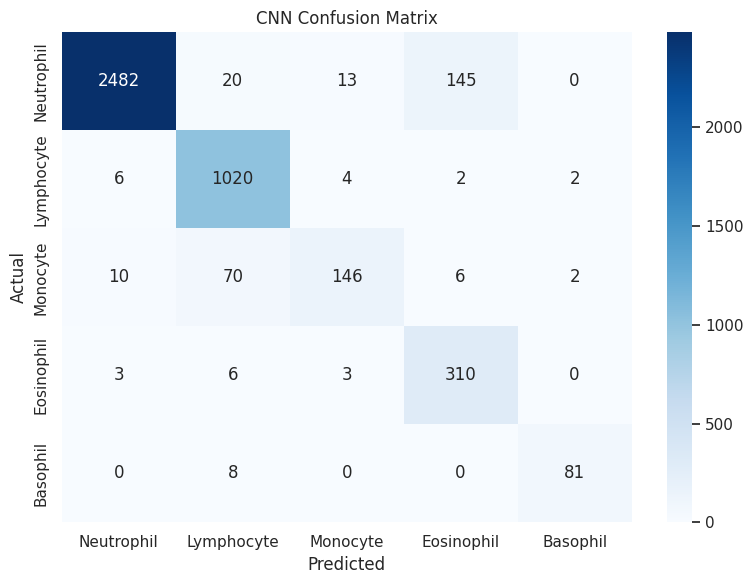

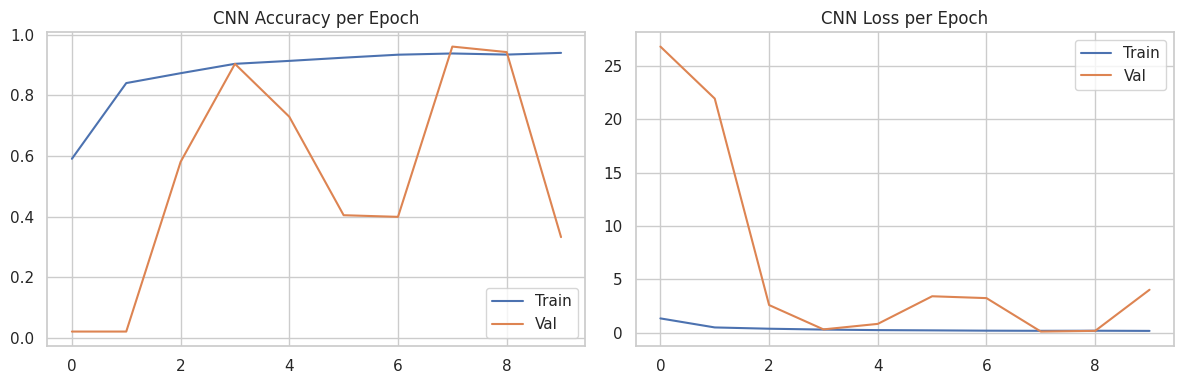

In [ ]:
callbacks_cnn = [
    ModelCheckpoint('best_wbc_model.keras', save_best_only=True,
                    monitor='val_accuracy', mode='max'),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
]

history_cnn = cnn_model.fit(
    augmenter_128.flow(X_train_128, y_train_128, batch_size=32),
    validation_data=(X_val_128, y_val_128),
    epochs=10,
    callbacks=callbacks_cnn,
    verbose=1,
)

test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test_128, y_test_128, verbose=1)
print("CNN Test Accuracy:", test_acc_cnn)

pred_probs_cnn = cnn_model.predict(X_test_128, verbose=0)
y_pred_cnn = np.argmax(pred_probs_cnn, axis=1)
y_true_cnn = np.argmax(y_test_128, axis=1)

print("\nCNN Classification Report:")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=class_names))

plt.figure(figsize=(8, 6))
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label="Train")
plt.plot(history_cnn.history['val_accuracy'], label="Val")
plt.title("CNN Accuracy per Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label="Train")
plt.plot(history_cnn.history['val_loss'], label="Val")
plt.title("CNN Loss per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


Fisher-style scores (train) - min: 1.0692210607061853e-11 max: 1.999998988958183 mean: 0.05528847877863446


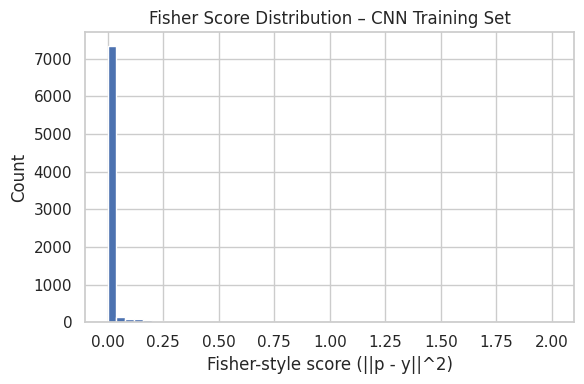

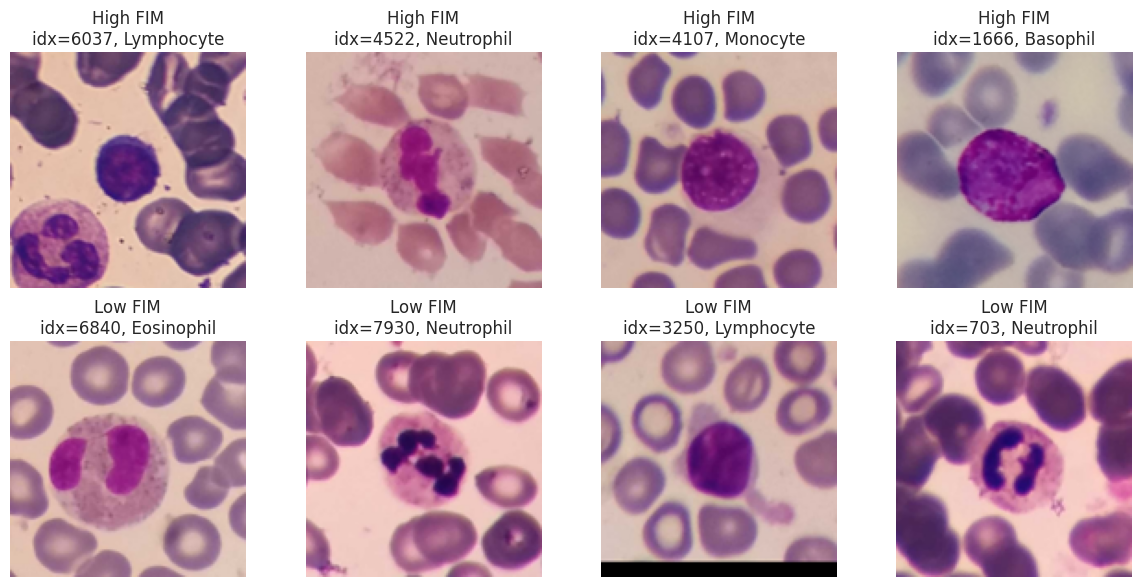

Example IF for test index: 2732 true label: Lymphocyte
  #1 Train idx=4107, label=Monocyte, IF=1.205e-01
  #2 Train idx=3616, label=Monocyte, IF=1.196e-01
  #3 Train idx=1802, label=Monocyte, IF=1.190e-01
  #4 Train idx=2675, label=Monocyte, IF=1.187e-01
  #5 Train idx=4110, label=Monocyte, IF=1.185e-01


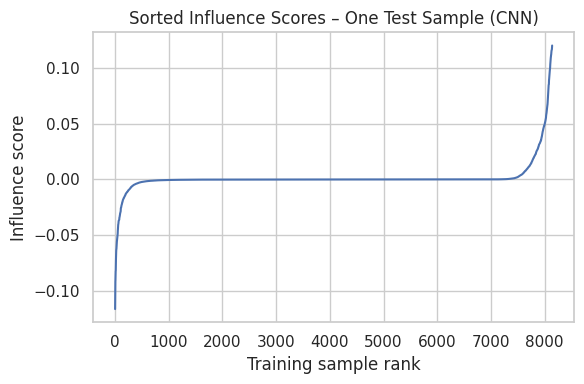

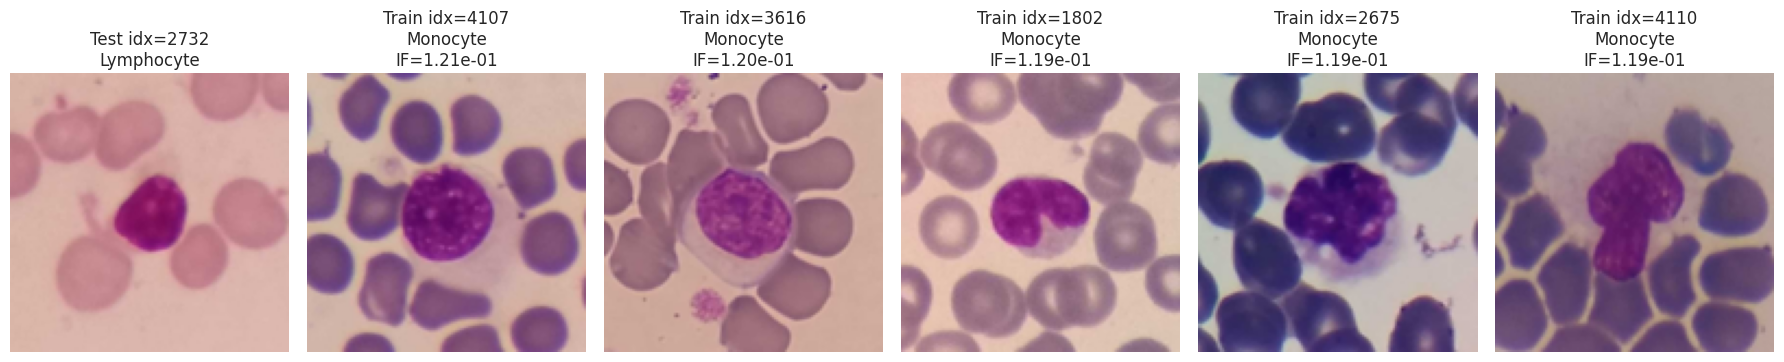

In [ ]:
def compute_probs_and_grads(model, X, y):

    probs = model.predict(X, verbose=0)
    grads = probs - y
    return probs, grads

# Gradients for train/test
train_probs_cnn, grad_train_cnn = compute_probs_and_grads(cnn_model, X_train_128, y_train_128)
test_probs_cnn, grad_test_cnn = compute_probs_and_grads(cnn_model, X_test_128, y_test_128)

# Fisher-style scores: ||p - y||^2
fisher_train = np.sum(grad_train_cnn**2, axis=1)
fisher_test = np.sum(grad_test_cnn**2, axis=1)

print("Fisher-style scores (train) - min:", fisher_train.min(),
      "max:", fisher_train.max(), "mean:", fisher_train.mean())

plt.figure(figsize=(6, 4))
plt.hist(fisher_train, bins=50)
plt.xlabel("Fisher-style score (||p - y||^2)")
plt.ylabel("Count")
plt.title("Fisher Score Distribution – CNN Training Set")
plt.tight_layout()
plt.savefig("fig_fisher_hist_train.png", dpi=200)
plt.show()

def show_fisher_examples(X, fisher_scores, y_one_hot, class_names, k=4):
    high_idx = np.argsort(-fisher_scores)[:k]
    low_idx = np.argsort(fisher_scores)[:k]

    plt.figure(figsize=(3*k, 6))

    for i, idx in enumerate(high_idx):
        plt.subplot(2, k, i+1)
        plt.imshow(X[idx])
        label = class_names[np.argmax(y_one_hot[idx])]
        plt.title(f"High FIM\nidx={idx}, {label}")
        plt.axis("off")

    for i, idx in enumerate(low_idx):
        plt.subplot(2, k, k + i + 1)
        plt.imshow(X[idx])
        label = class_names[np.argmax(y_one_hot[idx])]
        plt.title(f"Low FIM\nidx={idx}, {label}")
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("fig_fisher_examples.png", dpi=200)
    plt.show()

show_fisher_examples(X_train_128, fisher_train, y_train_128, class_names, k=4)

def get_influential_training_samples(test_index, top_k=10):
    """
    Influence approximation for CNN:
        I(i,j) ≈ - grad_train[i] ⋅ grad_test[j]
    """
    g_t = grad_test_cnn[test_index]                  # shape (C,)
    influence_scores = -np.dot(grad_train_cnn, g_t)  # shape (N_train,)
    sorted_idx = np.argsort(-influence_scores)
    top_idx = sorted_idx[:top_k]
    return top_idx, influence_scores[top_idx], influence_scores

# Example test index
np.random.seed(0)
test_idx_example = np.random.randint(0, len(X_test_128))
top_idx, top_scores, all_scores = get_influential_training_samples(test_idx_example, top_k=5)

print("Example IF for test index:", test_idx_example,
      "true label:", class_names[np.argmax(y_test_128[test_idx_example])])
for r, (ti, sc) in enumerate(zip(top_idx, top_scores), start=1):
    lbl = class_names[np.argmax(y_train_128[ti])]
    print(f"  #{r} Train idx={ti}, label={lbl}, IF={sc:.3e}")

plt.figure(figsize=(6, 4))
plt.plot(np.sort(all_scores))
plt.xlabel("Training sample rank")
plt.ylabel("Influence score")
plt.title("Sorted Influence Scores – One Test Sample (CNN)")
plt.tight_layout()
plt.savefig("fig_influence_curve.png", dpi=200)
plt.show()

def show_influence_example(test_index, top_k=5):
    top_idx, top_scores, _ = get_influential_training_samples(test_index, top_k)
    plt.figure(figsize=(3*(top_k+1), 4))

    plt.subplot(1, top_k+1, 1)
    plt.imshow(X_test_128[test_index])
    t_label = class_names[np.argmax(y_test_128[test_index])]
    plt.title(f"Test idx={test_index}\n{t_label}")
    plt.axis("off")

    for i, (ti, sc) in enumerate(zip(top_idx, top_scores), start=1):
        plt.subplot(1, top_k+1, i+1)
        plt.imshow(X_train_128[ti])
        tr_label = class_names[np.argmax(y_train_128[ti])]
        plt.title(f"Train idx={ti}\n{tr_label}\nIF={sc:.2e}")
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("fig_influence_examples.png", dpi=200)
    plt.show()

show_influence_example(test_idx_example, top_k=5)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D

# 1. Find last Conv2D layer name
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in model.")

last_conv_name = find_last_conv_layer(cnn_model)
print("Using last conv layer for Grad-CAM:", last_conv_name)


# 2. Compute Grad-CAM heatmap for a single image tensor x[1,H,W,3]
def compute_gradcam(model, img_tensor, class_index=None, conv_layer_name=None):
    """
    img_tensor: np.array or tf.Tensor of shape (1, H, W, 3), already normalized.
    class_index: int, target class. If None, uses argmax of model prediction.
    conv_layer_name: name of Conv2D layer. If None, uses last conv layer.
    Returns: heatmap as np.array (H, W) normalized to [0,1].
    """
    if conv_layer_name is None:
        conv_layer_name = find_last_conv_layer(model)

    conv_layer = model.get_layer(conv_layer_name)

    # Build model mapping input -> (feature_maps, predictions)
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [conv_layer.output, model.output]
    )

    # Forward + backward pass
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor, training=False)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        class_channel = predictions[:, class_index]

    # Gradient of class score w.r.t conv feature maps
    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
        return None

    # Global average pooling over H,W
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]              # (h,w,c)
    conv_outputs = conv_outputs * pooled_grads  # weight channels

    heatmap = tf.reduce_mean(conv_outputs, axis=-1)

    # Relu and normalize
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.math.reduce_max(heatmap) + 1e-8
    heatmap = heatmap / max_val

    return heatmap.numpy()


Using last conv layer for Grad-CAM: conv2d_7


In [ ]:
def show_gradcam_for_index(model, X, y_true_onehot, index, class_names, conv_layer_name=None):
    """
    Visualize Grad-CAM for one test example at given index.
    X: test images, normalized [0,1]
    y_true_onehot: one-hot labels
    index: integer index into X
    """
    # Prepare image
    img = X[index]                      # (H,W,3)
    img_batch = np.expand_dims(img, axis=0)

    # True and predicted class
    true_idx = int(np.argmax(y_true_onehot[index]))
    preds = model.predict(img_batch, verbose=0)
    pred_idx = int(np.argmax(preds[0]))
    pred_conf = float(preds[0][pred_idx])

    # Compute Grad-CAM heatmap
    heatmap = compute_gradcam(model, img_batch, class_index=pred_idx,
                              conv_layer_name=conv_layer_name)
    if heatmap is None:
        print("Grad-CAM could not be computed.")
        return

    # Resize heatmap to original image size
    h, w = img.shape[0], img.shape[1]
    heatmap_resized = cv2.resize(heatmap, (w, h))

    # Convert to color heatmap
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    img_uint8 = np.uint8(img * 255.0)
    img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)

    # Overlay
    alpha = 0.35
    overlay_bgr = cv2.addWeighted(heatmap_color, alpha, img_bgr, 1 - alpha, 0)
    overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

    # Plot: original, heatmap, overlay
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original\nTrue: {class_names[true_idx]}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_rgb)
    plt.title(f"Overlay\nPred: {class_names[pred_idx]} ({pred_conf*100:.1f}%)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
cnn_model.save("wbc_cnn_model.h5")
print("Model saved as wbc_cnn_model.h5")

cnn_model.save("wbc_cnn_model.keras")
print("Model saved as wbc_cnn_model.keras")


Model saved as wbc_cnn_model.h5
Model saved as wbc_cnn_model.keras


In [ ]:
print("="*60)
print("TRAINING RESNET50 MODEL")
print("="*60)

resnet_base = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in resnet_base.layers:
    layer.trainable = False

z = layers.Flatten()(resnet_base.output)
z = layers.Dense(150, activation='relu')(z)
output = layers.Dense(num_classes, activation='softmax')(z)
resnet_model = Model(resnet_base.input, output)

resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history_resnet = resnet_model.fit(
    augmenter_224.flow(X_train_224, y_train_224, batch_size=64),
    validation_data=(X_val_224, y_val_224),
    epochs=10,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1,
)

resnet_model.save("resnet50_wbc_model.keras")

loss_resnet, acc_resnet = resnet_model.evaluate(X_test_224, y_test_224, verbose=0)
y_pred_resnet = np.argmax(resnet_model.predict(X_test_224, verbose=0), axis=1)
y_true_resnet = np.argmax(y_test_224, axis=1)

print("ResNet50 Test Accuracy:", acc_resnet)
print("\nResNet50 Classification Report:")
print(classification_report(y_true_resnet, y_pred_resnet, target_names=class_names))


In [ ]:
results_df = pd.DataFrame({
    "Model": ["Custom CNN", "VGG16", "ResNet50"],
    "Accuracy": [test_acc_cnn, acc_vgg, acc_resnet],
    "Loss": [test_loss_cnn, loss_vgg, loss_resnet],
    "Input Size": ["128x128", "224x224", "224x224"],
})

print("Clean test performance:")
print(results_df.to_string(index=False))

plt.figure(figsize=(8, 5))
plt.bar(results_df["Model"], results_df["Accuracy"],
        color=["#3498db", "#2ecc71", "#e74c3c"])
plt.title("Model Accuracy Comparison (Clean Test Set)")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.0)
for i, row in results_df.iterrows():
    plt.text(i, row["Accuracy"] + 0.02, f"{row['Accuracy']:.4f}",
             ha="center", fontsize=11, fontweight="bold")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
def add_gaussian_noise(images, std=0.05):
    noisy = images + np.random.normal(0.0, std, images.shape)
    return np.clip(noisy, 0.0, 1.0)

def add_gaussian_blur(images, ksize=5):
    blurred = []
    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)
        b = cv2.GaussianBlur(img_uint8, (ksize, ksize), 0)
        blurred.append(b.astype(np.float32) / 255.0)
    return np.stack(blurred, axis=0)

def change_brightness(images, factor=1.3):
    out = images * factor
    return np.clip(out, 0.0, 1.0)

def evaluate_perturbation(model, X, y, perturb_fn=None):
    if perturb_fn is not None:
        X_eval = perturb_fn(X)
    else:
        X_eval = X
    probs = model.predict(X_eval, verbose=0)
    y_pred = np.argmax(probs, axis=1)
    y_true = np.argmax(y, axis=1)
    return accuracy_score(y_true, y_pred)

robust_results = {
    "Model": [],
    "Clean": [],
    "Noise": [],
    "Blur": [],
    "Bright": [],
}

# CNN (128x128)
robust_results["Model"].append("Custom CNN")
robust_results["Clean"].append(evaluate_perturbation(cnn_model, X_test_128, y_test_128, None))
robust_results["Noise"].append(evaluate_perturbation(
    cnn_model, X_test_128, y_test_128,
    perturb_fn=lambda x: add_gaussian_noise(x, std=0.05)))
robust_results["Blur"].append(evaluate_perturbation(
    cnn_model, X_test_128, y_test_128,
    perturb_fn=lambda x: add_gaussian_blur(x, ksize=5)))
robust_results["Bright"].append(evaluate_perturbation(
    cnn_model, X_test_128, y_test_128,
    perturb_fn=lambda x: change_brightness(x, factor=1.3)))

# VGG16 (224x224)
robust_results["Model"].append("VGG16")
robust_results["Clean"].append(evaluate_perturbation(vgg_model, X_test_224, y_test_224, None))
robust_results["Noise"].append(evaluate_perturbation(
    vgg_model, X_test_224, y_test_224,
    perturb_fn=lambda x: add_gaussian_noise(x, std=0.05)))
robust_results["Blur"].append(evaluate_perturbation(
    vgg_model, X_test_224, y_test_224,
    perturb_fn=lambda x: add_gaussian_blur(x, ksize=5)))
robust_results["Bright"].append(evaluate_perturbation(
    vgg_model, X_test_224, y_test_224,
    perturb_fn=lambda x: change_brightness(x, factor=1.3)))

# ResNet50 (224x224)
robust_results["Model"].append("ResNet50")
robust_results["Clean"].append(evaluate_perturbation(resnet_model, X_test_224, y_test_224, None))
robust_results["Noise"].append(evaluate_perturbation(
    resnet_model, X_test_224, y_test_224,
    perturb_fn=lambda x: add_gaussian_noise(x, std=0.05)))
robust_results["Blur"].append(evaluate_perturbation(
    resnet_model, X_test_224, y_test_224,
    perturb_fn=lambda x: add_gaussian_blur(x, ksize=5)))
robust_results["Bright"].append(evaluate_perturbation(
    resnet_model, X_test_224, y_test_224,
    perturb_fn=lambda x: change_brightness(x, factor=1.3)))

df_robust = pd.DataFrame(robust_results)
print("Robustness summary (accuracy under perturbations):")
print(df_robust.to_string(index=False))

conditions = ["Clean", "Noise", "Blur", "Bright"]
x = np.arange(len(conditions))
width = 0.25

plt.figure(figsize=(8, 5))
for i, name in enumerate(df_robust["Model"]):
    accs = [df_robust[c][i] for c in conditions]
    plt.bar(x + (i-1)*width, accs, width=width, label=name)

plt.xticks(x, conditions)
plt.ylim(0.0, 1.0)
plt.ylabel("Accuracy")
plt.title("Robustness Under Perturbations")
plt.legend()
plt.tight_layout()
plt.savefig("fig_robustness_bar.png", dpi=200)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Conv2D

# 1. Find last Conv2D layer name
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in model.")

last_conv_name = find_last_conv_layer(cnn_model)
print("Using last conv layer for Grad-CAM:", last_conv_name)


# 2. Compute Grad-CAM heatmap for a single image tensor x[1,H,W,3]
def compute_gradcam(model, img_tensor, class_index=None, conv_layer_name=None):
    """
    img_tensor: np.array or tf.Tensor of shape (1, H, W, 3), already normalized.
    class_index: int, target class. If None, uses argmax of model prediction.
    conv_layer_name: name of Conv2D layer. If None, uses last conv layer.
    Returns: heatmap as np.array (H, W) normalized to [0,1].
    """
    if conv_layer_name is None:
        conv_layer_name = find_last_conv_layer(model)

    conv_layer = model.get_layer(conv_layer_name)

    # Build model mapping input -> (feature_maps, predictions)
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [conv_layer.output, model.output]
    )

    # Forward + backward pass
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor, training=False)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        class_channel = predictions[:, class_index]

    # Gradient of class score w.r.t conv feature maps
    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
        return None

    # Global average pooling over H,W
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]              # (h,w,c)
    conv_outputs = conv_outputs * pooled_grads  # weight channels

    heatmap = tf.reduce_mean(conv_outputs, axis=-1)

    # Relu and normalize
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.math.reduce_max(heatmap) + 1e-8
    heatmap = heatmap / max_val

    return heatmap.numpy()
